In [34]:
# Install specific libraries
!pip install transformers
!pip install pycaret

import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# specify GPU
device = torch.device("cuda")


In [35]:

true_data = pd.read_csv('/content/True.csv', on_bad_lines='skip' , engine='python') # Skip lines that cause errors
fake_data = pd.read_csv('/content/Fake.csv', on_bad_lines='skip' , engine = 'python')


true_data['Target'] = ['True'] * len(true_data)
fake_data['Target'] = ['Fake'] * len(fake_data)

data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)


print(data.shape)
data.head()


(44898, 5)


,title,text,subject,date,Target
0,VIRAL VIDEO: UNIV OF WI Students Busted Agreei...,Watch the hypocrisy in action:,politics,"Mar 13, 2017",Fake
1,MOCKINGBIRD MIRROR: Declassified Docs Depict D...,"21st Century Wire says Over the past month, mo...",US_News,"March 1, 2017",Fake
2,Congressional Republicans Might Cause This De...,There has been a minor war brewing in Congress...,News,"May 12, 2016",Fake
3,First Somali Refugee Elected In American Hist...,"On November 8, 2016, Ilhan Omar made history a...",News,"December 8, 2016",Fake
4,Clash between military and suspected gang leav...,MEXICO CITY (Reuters) - The Mexican military f...,worldnews,"September 17, 2017",True


In [36]:
data['label'] = pd.get_dummies(data.Target)['Fake']
data.head()

,title,text,subject,date,Target,label
0,VIRAL VIDEO: UNIV OF WI Students Busted Agreei...,Watch the hypocrisy in action:,politics,"Mar 13, 2017",Fake,True
1,MOCKINGBIRD MIRROR: Declassified Docs Depict D...,"21st Century Wire says Over the past month, mo...",US_News,"March 1, 2017",Fake,True
2,Congressional Republicans Might Cause This De...,There has been a minor war brewing in Congress...,News,"May 12, 2016",Fake,True
3,First Somali Refugee Elected In American Hist...,"On November 8, 2016, Ilhan Omar made history a...",News,"December 8, 2016",Fake,True
4,Clash between military and suspected gang leav...,MEXICO CITY (Reuters) - The Mexican military f...,worldnews,"September 17, 2017",True,False


([<matplotlib.patches.Wedge at 0x78902e15e800>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.0971333070797922, 0.079363130584414, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.5984363493162502, 0.043288980318771264, '47.7%')])

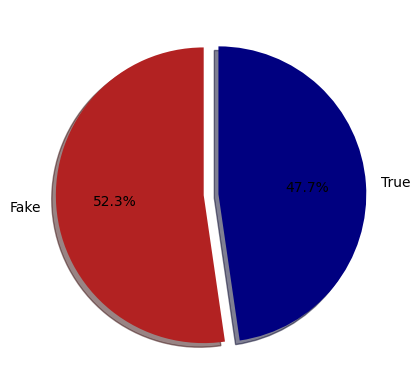

In [37]:
# Checking if our data is well balanced
label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]

plt.pie(label_size, explode=[0.1, 0], colors=['firebrick', 'navy'], startangle=90, shadow=True, labels=['Fake', 'True'], autopct='%1.1f%%')


In [38]:
###now we are doint the train test split for the data

# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(
    data['title'], data['label'],
    random_state=2018,
    test_size=0.3,
    stratify=data['label']
)

# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels
)


In [39]:
bert = AutoModel.from_pretrained('bert-base-cased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Text(0, 0.5, 'Number of Texts')

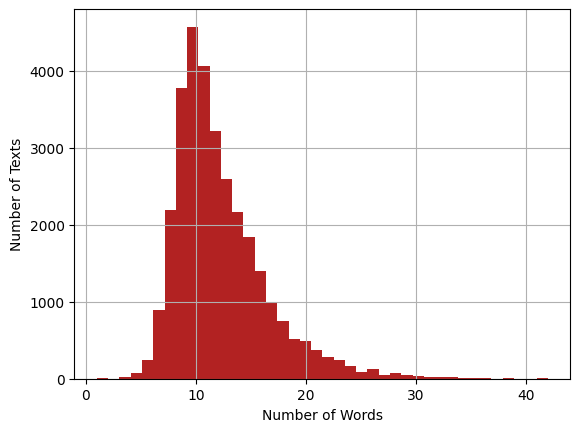

In [40]:
# Plotting
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins=40, color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')

In [41]:
# BERT Tokenizer Functionality
sample_data = ["Build fake news model.", "Using BERT."]
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding=True)  # encode text
print(tokenized_sample_data)

{'input_ids': [[101, 139, 19118, 8406, 2371, 2235, 119, 102], [101, 7993, 139, 9637, 1942, 119, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0]]}


In [42]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LEN = 15

# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LEN,
    pad_to_max_length=True,
    truncation=True
)

In [43]:
# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LEN,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LEN,
    pad_to_max_length=True,
    truncation=True
)


In [44]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [45]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Create a TensorDataset and DataLoader for the training set
train_data = TensorDataset(train_seq, train_mask, train_y)  # wrap tensors
train_sampler = RandomSampler(train_data)  # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)  # DataLoader for train set

# Create a TensorDataset and DataLoader for the validation set
val_data = TensorDataset(val_seq, val_mask, val_y)  # wrap tensors
val_sampler = SequentialSampler(val_data)  # sampler for sampling the data during validation
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)  # DataLoader for validation set


In [46]:
##now we have to freeze the layerss

for param in bert.parameters():
    param.requires_grad = False  # Setting requires_grad to False to freeze the layers

###freezing the layers dont update the pre trained weights during the back propogation

In [47]:
import torch.nn as nn
from transformers import AdamW


class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)  # dropout layer
        self.relu = nn.ReLU()            # ReLU activation function
        self.fc1 = nn.Linear(768, 512)   # dense layer 1
        self.fc2 = nn.Linear(512, 2)     # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1)  # softmax activation function

    def forward(self, sent_id, mask):
        # Get the CLS token's hidden state from BERT
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

        # Pass the CLS hidden state through the first dense layer
        x = self.fc1(cls_hs)
        x = self.relu(x)                # Apply ReLU activation
        x = self.dropout(x)             # Apply dropout
        x = self.fc2(x)                 # Pass through the second dense layer (output layer)
        x = self.softmax(x)             # Apply softmax activation
        return x

# Instantiate the model using the BERT base model
model = BERT_Arch(bert)

# Define the optimizer (AdamW)
optimizer = AdamW(model.parameters(), lr=1e-3)  # learning rate is set to 0.001

# Define the loss function (negative log likelihood)
cross_entropy = nn.NLLLoss()

# Number of training epochs
epochs = 2

###Training and evaluating the function


In [48]:
###changed this later

device = torch.device("cpu")



def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_dataloader):  # iterate over batches
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))  # progress update after every 50 batches

        batch = [r.to(device) for r in batch]  # push the batch to gpu

        sent_id, mask, labels = batch
        model.zero_grad()  # clear previously calculated gradients
        preds = model(sent_id, mask)  # get model predictions for current

        # Convert labels to LongTensor
        labels = labels.long()


        loss = cross_entropy(preds, labels)  # compute loss between actual & predicted values
        total_loss = total_loss + loss.item()  # add on to the total loss
        loss.backward()  # backward pass to calculate the gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip gradients to 1.0. It helps in preventing exploding gradient problem
        optimizer.step()  # update parameters

        preds = preds.detach().cpu().numpy()  # model predictions are stored on GPU. So, push it to CPU

    avg_loss = total_loss / len(train_dataloader)  # compute training loss of the epoch
    return avg_loss


In [49]:
def evaluate():
    print("\nEvaluating...")

    model.eval()  # Deactivate dropout layers
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(val_dataloader):  # Iterate over batches
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))  # Progress update every 50 batches

       # batch = [t for t in batch]  # Push the batch to GPU

        sent_id, mask, labels = batch

        # Convert labels to LongTensor
        labels = labels.long()  # Ensure labels are LongTensor

        with torch.no_grad():  # Deactivate autograd
            preds = model(sent_id, mask)  # Model predictions
            loss = cross_entropy(preds, labels)  # Compute the validation loss between actual and predicted values
            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()  # Push predictions to CPU

    avg_loss = total_loss / len(val_dataloader)  # Compute the validation loss of the epoch

    return avg_loss


###Model Training



In [33]:
# Initialize variables to track the best validation loss and store training/validation losses
best_valid_loss = float('inf')  # Initialize best validation loss to infinity
train_losses = []  # Empty list to store training losses of each epoch
valid_losses = []  # Empty list to store validation losses of each epoch

# Loop over the number of epochs
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss = train()  # Train the model and get the training loss
    valid_loss = evaluate()  # Evaluate the model and get the validation loss

    # Check if the current validation loss is the best we've seen so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss  # Update the best validation loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')  # Save the best model's weights

    # Append the current epoch's losses to the respective lists
    train_losses.append(train_loss)  # Append training loss
    valid_losses.append(valid_loss)  # Append validation loss

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    969.
  Batch   100  of    969.
  Batch   150  of    969.
  Batch   200  of    969.
  Batch   250  of    969.
  Batch   300  of    969.
  Batch   350  of    969.
  Batch   400  of    969.
  Batch   450  of    969.
  Batch   500  of    969.
  Batch   550  of    969.
  Batch   600  of    969.
  Batch   650  of    969.
  Batch   700  of    969.
  Batch   750  of    969.
  Batch   800  of    969.
  Batch   850  of    969.
  Batch   900  of    969.
  Batch   950  of    969.

Evaluating...
  Batch    50  of    208.
  Batch   100  of    208.
  Batch   150  of    208.
  Batch   200  of    208.

Training Loss: 0.062
Validation Loss: 0.033

 Epoch 2 / 2
  Batch    50  of    969.
  Batch   100  of    969.
  Batch   150  of    969.
  Batch   200  of    969.
  Batch   250  of    969.
  Batch   300  of    969.
  Batch   350  of    969.
  Batch   400  of    969.
  Batch   450  of    969.
  Batch   500  of    969.
  Batch   550  of    969.
  Batch   600  of    969.
  

In [51]:
# Load weights of best model
path = '/content/c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))
print("<All keys matched successfully>")

<All keys matched successfully>


In [52]:
# Evaluate the model on the test set
with torch.no_grad():
    preds = model(test_seq, test_mask)  # Get predictions
    preds = preds.detach().cpu().numpy()  # Move predictions to CPU and convert to numpy array

    preds = np.argmax(preds, axis=1)  # Get the index of the max log-probability (i.e., the predicted class)
    print(classification_report(test_y, preds))  # Print the classification report

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      3212
        True       0.99      0.99      0.99      3523

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



In [53]:
# Testing on unseen data
unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year's Eve Message; This is Disturbing",  # Fake
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",  # Fake
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",  # True
    "Trump administration issues new rules on U.S. visa waivers"  # True
]

# Tokenize and encode sequences in the unseen data
MAX_LEN = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LEN,
    pad_to_max_length=True,
    truncation=True
)

# Convert tokens to tensors
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

# Model predictions on unseen data
with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
preds


array([1, 1, 0, 0])